In [1]:
from pygeotools.lib import  geolib, malib, iolib, warplib
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import rasterio, affine
from rasterio import features
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

#### Currently use  an already available wrapper around GSLIB https://github.com/GeostatsGuy/GeostatsPy/

In [3]:
import sys
GeoPy_path='/home/shashank/nobackup_shashank/gslib_executables/GeostatsPy/'
sys.path.insert(0, GeoPy_path)
import GeostatsPy

In [4]:
shp_fn='../../raster_geostatistics/data/Sikkim_kanchenjunga.shp'
raster_fn='../../raster_geostatistics/data/Rate_maps_Coregister-tile-0-last_inverted_ref.tif'

In [5]:
shp_gdf=gpd.read_file(shp_fn)
rasterio_dataset= rasterio.open(raster_fn)
gt_r=rasterio_dataset.transform
##### To convert back and forth from the gdal tuple to affine transform
#https://www.perrygeo.com/python-affine-transforms.html
gt_rp = gt_r.to_gdal()
array_rasterio_masked=rasterio_dataset.read(1, masked=True)

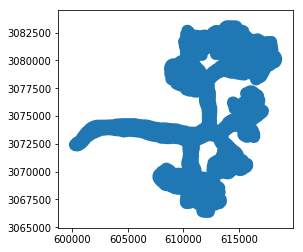

In [6]:
shp_gdf_projected_raster=shp_gdf.copy()
shp_gdf_projected_raster=shp_gdf_projected_raster.to_crs(rasterio_dataset.crs)
shp_gdf_projected_buffer=shp_gdf_projected_raster.copy()
shp_gdf_projected_buffer['geometry']=shp_gdf_projected_buffer.buffer(500)
shp_gdf_projected_buffer.plot()

In [7]:
shape_array=features.rasterize(shp_gdf_projected_buffer.geometry, out_shape=array_rasterio_masked.shape,fill=-9999,transform=rasterio_dataset.transform,dtype=float)
shape_masked=np.ma.masked_where(shape_array==-9999, shape_array)
glacier_cutoff=np.ma.array(array_rasterio_masked, mask=shape_masked.mask)

### Trimming the masked array and associated gt

In [8]:
##*****Potential Function******##
#trim the array
trim_ar=malib.masktrim(glacier_cutoff)
#trim the gt
print("input gt", gt_r)
edge_env = malib.edgefind2(glacier_cutoff)
out_gt=list(gt_rp)
#update UL_X
out_gt[0] = gt_rp[0] + gt_rp[1]*edge_env[2]
#Update UL_y
out_gt[3] = gt_rp[3] + gt_rp[5]*edge_env[0]
out_gt = tuple(out_gt)
#convert to rasterio gt
out_gt_r=affine.Affine.from_gdal(*out_gt)
print("Output gt",out_gt_r)

input gt | 10.00, 0.00, 551333.39|
| 0.00,-10.00, 3115850.78|
| 0.00, 0.00, 1.00|
Output gt | 10.00, 0.00, 599713.39|
| 0.00,-10.00, 3083580.78|
| 0.00, 0.00, 1.00|


### Reading xyz

In [9]:
x, y = geolib.get_xy_ma(trim_ar, gt=out_gt, origmask=True)
xyz = np.vstack((x.compressed(),y.compressed(),trim_ar.compressed())).T
df=pd.DataFrame(xyz,columns=['x','y','dh'])
df.head()

,x,y,dh
0,613748.392595,3.083576e+06,-0.436620
1,613668.392595,3.083546e+06,-9.811455
2,613648.392595,3.083536e+06,-4.753187
3,613658.392595,3.083536e+06,-8.136490
4,613668.392595,3.083536e+06,-10.443363


### Declusterring data, assigning them wiegths


In [10]:
#weights=GeostatsPy.declus(df,'x','y','dh',100,1000,5,0)

### nscore transform

In [11]:
dh_nscore=GeostatsPy.nscore(df.dh.values,df.dh.count())
#### Error in data file problem, this expects a datafile, it probably expects a data

In [12]:
df.dh.values

array([-0.43662035, -9.81145477, -4.75318718, ...,  0.1187715 ,
       -5.2203784 , -6.97474861])

In [13]:
dh_nscore.head(4)

,value,NS:value
0,-0.436620,-0.30298
1,-9.811455,-2.09781
2,-4.753187,-1.63625
3,-8.136490,-1.97881


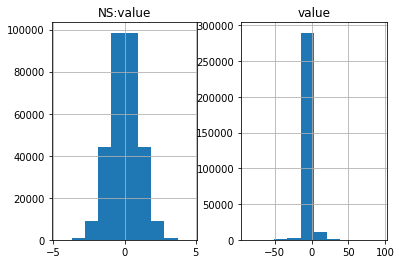

In [14]:
hist=dh_nscore.hist()

In [15]:
df=df.assign(nscore=dh_nscore['NS:value'].values)

In [16]:
df.tail()

,x,y,dh,nscore
304130,611478.392595,3.065966e+06,-7.042507,-1.88915
304131,611488.392595,3.065966e+06,-6.405008,-1.82628
304132,611458.392595,3.065956e+06,0.118772,0.34019
304133,611468.392595,3.065956e+06,-5.220378,-1.69431
304134,611478.392595,3.065956e+06,-6.974749,-1.88285


#### experimental variogram

In [17]:
lag_x,gamma_x,npair_x=GeostatsPy.gamv_2d(df,'x','y','nscore',20,10,90,0,1)


In [18]:
lag_x

[0.0,
 0.0,
 12.73,
 21.565,
 29.954,
 40.947,
 51.374,
 60.518,
 70.609,
 80.408,
 90.563,
 100.966,
 110.76,
 120.31,
 130.112,
 140.516,
 150.003,
 159.882,
 170.727,
 181.054,
 190.657,
 199.992]

In [19]:
lag_y,gamma_y,npair_y=GeostatsPy.gamv_2d(df,'x','y','nscore',20,10,0,0,1)

In [22]:
gamma_y

[0.0,
 0.0,
 0.12242,
 0.2051,
 0.28328,
 0.37082,
 0.43983,
 0.49188,
 0.53818,
 0.57266,
 0.60435,
 0.62901,
 0.65327,
 0.6647,
 0.67711,
 0.68007,
 0.6817,
 0.68409,
 0.68349,
 0.68883,
 0.68728,
 0.68705]

#### Modeled spherical variogram and plotting

In [21]:
lags=np.array([lag_x,lag_y])
gammas=np.array([gamma_x,gamma_y])
vtype=[0,0]
name=['Azi 00','Azi 90']
lag_x_mod,gamma_x_mod = GeostatsPy.vmodel_2d(nlag=20,azi=90,step=10,nug=0,nst=1,tstr1=1,c1=1.0,azi1=90,rmaj1=700,rmin1=430)
lag_y_mod,gamma_y_mod = GeostatsPy.vmodel_2d(nlag=20,azi=0,step=10,nug=0,nst=1,tstr1=1,c1=1.0,azi1=90,rmaj1=700,rmin1=430)

lags = np.array([lag_x,lag_y,lag_x_mod,lag_y_mod])                # combine into in lists of arrays to pass to plotting
gammas = np.array([gamma_x,gamma_y,gamma_x_mod,gamma_y_mod])
npairs = np.array([npair_x,npair_y])
vtype = [0,0,1,1]                                                 # indicate that the two variograms are experimental
name = ['Azi 090','Azi 000','Model 090','Model 000']              # give the variograms names
GeostatsPy.vargplts(lags,gammas,npairs,vtype,name,0,700,0,1.2,1,"Test of Experimental and Model Variogram Calculation and Visualization",plt.cm.plasma)


NameError: name 'lags' is not defined

<Figure size 576x432 with 0 Axes>

## To Do
#### nscore, experimental and model variogram done, fix error in plotting section of wrapper and try to attempt SGSIM